# Week 4 - Convolutional Neural Networks

## Importing libraries and dependencies

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

## Convert images into Tensors

In [82]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])



In [83]:
train_data = ImageFolder(
    "clouds_dataset/clouds_train",
    transform = transform
)

In [84]:
train_data

Dataset ImageFolder
    Number of datapoints: 474
    Root location: clouds_dataset/clouds_train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomAutocontrast(p=0.5)
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
           )

In [85]:
test_data = ImageFolder(
    "clouds_dataset/clouds_test",
    transform = transform
)

In [86]:
test_data

Dataset ImageFolder
    Number of datapoints: 486
    Root location: clouds_dataset/clouds_test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomAutocontrast(p=0.5)
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
           )

## Creating loaders

In [87]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Creating the model class

In [88]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Locally connected layer  
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=num_classes)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, 64 * 16 * 16)

        x = self.fc1(x)

        return F.log_softmax(x, dim=1)

## Create an instance of the model

In [89]:
num_classes = len(train_data.classes)
print(f"Classes found: {train_data.classes}")
print(f"Number of classes: {num_classes}")

Classes found: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']
Number of classes: 7


In [90]:
torch.manual_seed(41)
model = ConvolutionalNeuralNetwork(num_classes)
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=7, bias=True)
)

## Define loss function optimizer

In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train and Test

In [ ]:
epochs = 50
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    current_train_loss = 0 # To accumulate training loss for the epoch

    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1 # Start batches at 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train) # Compare predictions to correct answers
        current_train_loss += loss.item() # Accumulate loss

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)
    train_correct.append(trn_corr) 

    # Test
    with torch.no_grad(): # No gradient
        current_test_loss = 0 # To accumulate test loss for the epoch
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            loss_test = criterion(y_val, y_test) # Calculate loss for test set
            current_test_loss += loss_test.item()

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    # Average test loss for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

    # Print results at the end of each epoch
    print(f'Epoch {i+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/10, Loss: 1.1598
Epoch 2/10, Loss: 1.1588
Epoch 3/10, Loss: 1.2560
Epoch 4/10, Loss: 1.3124
Epoch 5/10, Loss: 1.4915
Epoch 6/10, Loss: 1.0617
Epoch 7/10, Loss: 0.9673
Epoch 8/10, Loss: 1.0951
Epoch 9/10, Loss: 1.7678
Epoch 10/10, Loss: 0.8983


## Loss at each Epoch

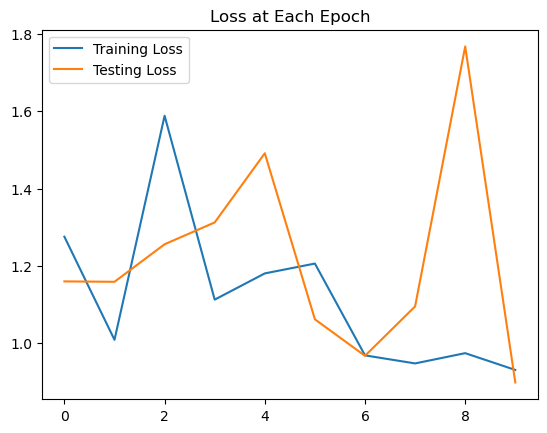

In [99]:
# Transform tensors into a list
train_losses = [tl.item() for tl in train_losses]

# Graph loss at each epoch
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at Each Epoch')
plt.legend()

# Accuracy at the end of each epoch

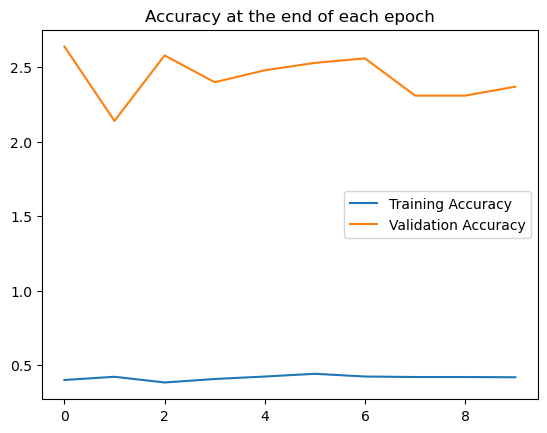

In [100]:
# Graph accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

## Percentage of Accuracy

In [101]:
test_load_everything = DataLoader(test_data, batch_size=486, shuffle=False)

In [102]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [103]:
correct.item()/len(test_data)

0.4732510288065844